In [1]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn import metrics

In [2]:
features_stock = pd.read_csv('feature_stock1.csv')
features_stock2 = pd.read_csv('feature_stock2.csv')
features_stock = features_stock.merge(features_stock2, on=['trade_date', 'ts_code'], how='left')
del features_stock2
feature_index = pd.read_csv('feature_index.csv')
features_stock = features_stock.merge(feature_index[['trade_date', 'rate', 'rate_1', 'rate_2']], on='trade_date', how='left')
del feature_index

In [3]:
features_stock.columns

Index(['turnover_rate', 'open_transform', 'close_transform', 'high_transform',
       'low_transform', 'zhenfu', 'zhangting', 'open_transform_1',
       'open_transform_2', 'close_transform_1', 'close_transform_2',
       'high_transform_1', 'high_transform_2', 'low_transform_1',
       'low_transform_2', 'zhenfu_1', 'zhenfu_2', 'zhangting_1', 'zhangting_2',
       'month', 'weekday', 'trade_date', 'ts_code', 'open', 'high', 'low',
       'close', 'pre_close', 'next_close', 'rate', 'rate_1', 'rate_2'],
      dtype='object')

In [4]:
feature_col=['turnover_rate', 'open_transform', 'close_transform', 'high_transform',
       'low_transform', 'zhenfu', 'zhangting', 'open_transform_1',
       'open_transform_2', 'close_transform_1', 'close_transform_2',
       'high_transform_1', 'high_transform_2', 'low_transform_1',
       'low_transform_2', 'zhenfu_1', 'zhenfu_2', 'zhangting_1', 'zhangting_2',
       'weekday', 'rate', 'rate_1', 'rate_2']

In [5]:
features_stock = features_stock.rename(columns={'ts_code':'name', 'trade_date':'day', 'close':'close_price'})
features = features_stock

In [6]:
features = features.dropna().reset_index(drop=True)

In [7]:
features['label'] = ((features['next_close'] / features['close_price'] - 1) > 0)

In [8]:
train_date_min = 20170101
train_date_max = 20190101

val_date_min = 20190102
val_date_max = 20200401

idx = (features['day'] >= train_date_min) & (features['day'] <= train_date_max)
trn = features[idx][feature_col].values
trn_label = features[idx]['label'].values

idx = (features['day'] >= val_date_min) & (features['day'] <= val_date_max)
val = features[idx][feature_col].values
val_label = features[idx]['label'].values

day_list = features[idx]['day'].unique()

In [9]:
print('rate of 1: %.4f' % (np.sum(trn_label==1)/len(trn_label)))
print('trn data:%d, val data:%d' % (len(trn), len(val)))
print('number of features:%d' % len(feature_col))
print(feature_col)

rate of 1: 0.4715
trn data:1235699, val data:838951
number of features:23
['turnover_rate', 'open_transform', 'close_transform', 'high_transform', 'low_transform', 'zhenfu', 'zhangting', 'open_transform_1', 'open_transform_2', 'close_transform_1', 'close_transform_2', 'high_transform_1', 'high_transform_2', 'low_transform_1', 'low_transform_2', 'zhenfu_1', 'zhenfu_2', 'zhangting_1', 'zhangting_2', 'weekday', 'rate', 'rate_1', 'rate_2']


In [11]:
# 模型训练及评价
import lightgbm as lgb
from sklearn import metrics
param = {'num_leaves': 31,
#          'min_data_in_leaf': 20,
         'objective': 'binary',
         'learning_rate': 0.06,
         "boosting": "gbdt",
#          "bagging_freq": 1,
#          "bagging_seed": 11,
#          'objective':'multiclass',
#          'num_class':3,
         "metric": 'auc',
         "verbosity": -1}
trn_data = lgb.Dataset(trn, trn_label)
val_data = lgb.Dataset(val, val_label)
num_round = 500
# clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=100,
#                 early_stopping_rounds=100)
clf = lgb.train(param, trn_data, num_round)
# oof_lgb = clf.predict(val, num_iteration=clf.best_iteration)
test_lgb = clf.predict(val, num_iteration=clf.best_iteration)

In [12]:
pd.DataFrame({
        'column': feature_col,
        'importance': clf.feature_importance(),
    }).sort_values(by='importance', ascending=False)

,column,importance
20,rate,3106
21,rate_1,3051
22,rate_2,2778
19,weekday,961
2,close_transform,647
9,close_transform_1,522
0,turnover_rate,510
3,high_transform,404
4,low_transform,399
10,close_transform_2,388


In [14]:
oof = test_lgb > 0.6
idx = (features['day'] >= val_date_min) & (features['day'] <= val_date_max)
buy_df = features[idx]
buy_df['pred'] = oof
buy_df['prob'] = test_lgb

# buy_df['is_limit_up'] = (buy_df['close_price'] == buy_df['high']) #(buy_df['close_price'] == buy_df['high']) | 
buy_df = buy_df[(buy_df['pred']==1) & ((buy_df['zhangting']==False)&(buy_df['close_transform']<1.15))]
# buy_df = buy_df[(buy_df['is_limit_up']==False)].reset_index(drop=True)

E:\software\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
E:\software\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [15]:
sum(buy_df['pred']*buy_df['label']) / len(buy_df)

E:\software\anaconda\lib\site-packages\pandas\core\computation\expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


0.5792249114160636

In [16]:
buy_df['next_open'] = buy_df['next_close']

In [17]:
from imp import reload
import Account
reload(Account)
money_init = 100000
account = Account.Account(money_init)
account.BackTest(buy_df, sorted(day_list), buy_price='close_price')

20190102  买入 002450.SZ (002450.SZ) 3400股，股价：7.24,花费：24616.0,手续费：7.38，剩余现金：75376.62
20190102  买入 002790.SZ (002790.SZ) 4000股，股价：6.1156,花费：24462.4,手续费：7.34，剩余现金：50906.88
20190102  买入 603365.SH (603365.SH) 1800股，股价：13.8171,花费：24870.78,手续费：7.46，剩余现金：26028.64
20190102  买入 603679.SH (603679.SH) 1100股，股价：21.9563,花费：24151.93,手续费：7.25，剩余现金：1869.46
20190103  止损卖出 (002450.SZ) 3400股，股价：6.95,收入：23630.0,手续费：30.72，剩余现金：25468.74，最终亏损：-1024.1
20190103  止损卖出 (002790.SZ) 4000股，股价：6.1156,收入：24462.4,手续费：31.8，剩余现金：49899.34，最终亏损：-39.14
20190103  止损卖出 (603365.SH) 1800股，股价：13.7016,收入：24662.88,手续费：32.06，剩余现金：74530.16，最终亏损：-247.42
20190103  止损卖出 (603679.SH) 1100股，股价：21.4473,收入：23592.03,手续费：30.67，剩余现金：98091.52，最终亏损：-597.82
20190103  买入 002050.SZ (002050.SZ) 2600股，股价：9.2768,花费：24119.68,手续费：7.24，剩余现金：73964.6
20190104  止盈卖出 (002050.SZ) 2600股，股价：9.5341,收入：24788.66,手续费：32.23，剩余现金：98721.04，最终盈利：629.52
20190107  买入 002358.SZ (002358.SZ) 1400股，股价：16.7112,花费：23395.68,手续费：7.02，剩余现金：75318.34
20190107  买入 002099.SZ (002099.S

20190215  止盈卖出 (002322.SZ) 2500股，股价：9.7097,收入：24274.25,手续费：31.56，剩余现金：74700.43，最终盈利：249.75
20190215  止损卖出 (002511.SZ) 2900股，股价：7.8952,收入：22896.08,手续费：29.76，剩余现金：97566.75，最终亏损：-1021.19
20190215  买入 002601.SZ (002601.SZ) 1800股，股价：13.0715,花费：23528.7,手续费：7.06，剩余现金：74030.99
20190218  止盈卖出 (002601.SZ) 1800股，股价：13.2229,收入：23801.22,手续费：30.94，剩余现金：97801.27，最终盈利：234.52
20190218  买入 603288.SH (603288.SH) 300股，股价：75.8956,花费：22768.68,手续费：6.83，剩余现金：75025.76
20190218  买入 600009.SH (600009.SH) 400股，股价：52.8,花费：21120.0,手续费：6.34，剩余现金：53899.42
20190218  买入 603365.SH (603365.SH) 1600股，股价：14.9429,花费：23908.64,手续费：7.17，剩余现金：29983.61
20190218  买入 000799.SZ (000799.SZ) 1300股，股价：18.5499,花费：24114.87,手续费：7.23，剩余现金：5861.5
20190218  买入 600000.SH (600000.SH) 500股，股价：10.5134,花费：5256.7,手续费：5，剩余现金：599.8
20190219  止损卖出 (603288.SH) 300股，股价：75.055,收入：22516.5,手续费：29.27，剩余现金：23087.03，最终亏损：-288.28
20190219  止盈卖出 (600009.SH) 400股，股价：54.0699,收入：21627.96,手续费：28.12，剩余现金：44686.88，最终盈利：473.51
20190219  止损卖出 (603365.SH) 1600股，股价：14.

20190314  止盈卖出 (600511.SH) 1000股，股价：24.6596,收入：24659.6,手续费：32.06，剩余现金：55192.74，最终盈利：58.87
20190314  止盈卖出 (600141.SH) 2300股，股价：11.4734,收入：26388.82,手续费：34.31，剩余现金：81547.26，最终盈利：454.27
20190314  止损卖出 (002852.SZ) 1800股，股价：13.9876,收入：25177.68,手续费：32.73，剩余现金：106692.21，最终亏损：-478.36
20190314  买入 600185.SH (600185.SH) 5500股，股价：4.76,花费：26180.0,手续费：7.85，剩余现金：80504.35
20190314  买入 002905.SZ (002905.SZ) 1600股，股价：15.7488,花费：25198.08,手续费：7.56，剩余现金：55298.71
20190314  买入 600054.SH (600054.SH) 2400股，股价：10.6914,花费：25659.36,手续费：7.7，剩余现金：29631.66
20190314  买入 002800.SZ (002800.SZ) 1300股，股价：19.8603,花费：25818.39,手续费：7.75，剩余现金：3805.52
20190315  止盈卖出 (600185.SH) 5500股，股价：4.95,收入：27225.0,手续费：35.39，剩余现金：30995.13，最终盈利：1001.75
20190315  止盈卖出 (002905.SZ) 1600股，股价：16.1228,收入：25796.48,手续费：33.54，剩余现金：56758.07，最终盈利：557.31
20190315  止盈卖出 (600054.SH) 2400股，股价：11.1056,收入：26653.44,手续费：34.65，剩余现金：83376.86，最终盈利：951.73
20190315  止盈卖出 (002800.SZ) 1300股，股价：20.5097,收入：26662.61,手续费：34.66，剩余现金：110004.81，最终盈利：801.81
20190315  买入 601

20190409  止盈卖出 (600385.SH) 2800股，股价：10.92,收入：30576.0,手续费：39.75，剩余现金：120621.43，最终盈利：1547.56
20190409  买入 601615.SH (601615.SH) 2100股，股价：13.5388,花费：28431.48,手续费：8.53，剩余现金：92181.42
20190409  买入 601865.SH (601865.SH) 2000股，股价：14.1013,花费：28202.6,手续费：8.46，剩余现金：63970.36
20190409  买入 002395.SZ (002395.SZ) 1800股，股价：16.0742,花费：28933.56,手续费：8.68，剩余现金：35028.12
20190409  买入 603131.SH (603131.SH) 1500股，股价：19.1103,花费：28665.45,手续费：8.6，剩余现金：6354.07
20190410  止损卖出 (601615.SH) 2100股，股价：13.3499,收入：28034.79,手续费：36.45，剩余现金：34352.41，最终亏损：-441.66
20190410  止损卖出 (601865.SH) 2000股，股价：13.9424,收入：27884.8,手续费：36.25，剩余现金：62200.96，最终亏损：-362.51
20190410  止损卖出 (002395.SZ) 1800股，股价：16.0742,收入：28933.56,手续费：37.61，剩余现金：91096.91，最终亏损：-46.29
20190410  止损卖出 (603131.SH) 1500股，股价：18.9042,收入：28356.3,手续费：36.86，剩余现金：119416.35，最终亏损：-354.61
20190410  买入 002946.SZ (002946.SZ) 1600股，股价：18.4163,花费：29466.08,手续费：8.84，剩余现金：89941.43
20190410  买入 603896.SH (603896.SH) 700股，股价：41.6893,花费：29182.51,手续费：8.75，剩余现金：60750.16
20190410  买入 600711.S

20190509  买入 002223.SZ (002223.SZ) 1400股，股价：21.9531,花费：30734.34,手续费：9.22，剩余现金：92431.32
20190509  买入 600196.SH (600196.SH) 1200股，股价：25.3939,花费：30472.68,手续费：9.14，剩余现金：61949.5
20190509  买入 002174.SZ (002174.SZ) 1600股，股价：18.9,花费：30240.0,手续费：9.07，剩余现金：31700.43
20190509  买入 002422.SZ (002422.SZ) 1100股，股价：27.484,花费：30232.4,手续费：9.07，剩余现金：1458.96
20190510  止盈卖出 (002223.SZ) 1400股，股价：23.2147,收入：32500.58,手续费：42.25，剩余现金：33917.29，最终盈利：1714.77
20190510  止盈卖出 (600196.SH) 1200股，股价：26.1742,收入：31409.04,手续费：40.83，剩余现金：65285.49，最终盈利：886.39
20190510  止盈卖出 (002174.SZ) 1600股，股价：20.2,收入：32320.0,手续费：42.02，剩余现金：97563.48，最终盈利：2028.91
20190510  止盈卖出 (002422.SZ) 1100股，股价：28.4571,收入：31302.81,手续费：40.69，剩余现金：128825.6，最终盈利：1020.65
20190510  买入 600287.SH (600287.SH) 4200股，股价：7.2829,花费：30588.18,手续费：9.18，剩余现金：98228.24
20190510  买入 002808.SZ (002808.SZ) 3200股，股价：9.5016,花费：30405.12,手续费：9.12，剩余现金：67814.0
20190510  买入 600587.SH (600587.SH) 1800股，股价：16.5579,花费：29804.22,手续费：8.94，剩余现金：38000.84
20190510  买入 603906.SH (603906.SH) 

20190617  买入 603858.SH (603858.SH) 1900股，股价：17.7684,花费：33759.96,手续费：10.13，剩余现金：108165.86
20190617  买入 000598.SZ (000598.SZ) 7900股，股价：4.45,花费：35155.0,手续费：10.55，剩余现金：73000.31
20190617  买入 600965.SH (600965.SH) 3300股，股价：10.56,花费：34848.0,手续费：10.45，剩余现金：38141.86
20190617  买入 002839.SZ (002839.SZ) 6300股，股价：5.59,花费：35217.0,手续费：10.57，剩余现金：2914.29
20190618  止盈卖出 (603858.SH) 1900股，股价：18.1339,收入：34454.41,手续费：44.79，剩余现金：37323.91，最终盈利：639.53
20190618  止损卖出 (000598.SZ) 7900股，股价：4.45,收入：35155.0,手续费：45.7，剩余现金：72433.21，最终亏损：-56.25
20190618  止盈卖出 (600965.SH) 3300股，股价：10.6,收入：34980.0,手续费：45.47，剩余现金：107367.74，最终盈利：76.07
20190618  止损卖出 (002839.SZ) 6300股，股价：5.57,收入：35091.0,手续费：45.62，剩余现金：142413.12，最终亏损：-182.18
20190620  买入 002350.SZ (002350.SZ) 5400股，股价：6.51,花费：35154.0,手续费：10.55，剩余现金：107248.57
20190620  买入 002915.SZ (002915.SZ) 1600股，股价：22.2,花费：35520.0,手续费：10.66，剩余现金：71717.92
20190621  止盈卖出 (002350.SZ) 5400股，股价：6.52,收入：35208.0,手续费：45.77，剩余现金：106880.15，最终盈利：-2.32
20190621  止损卖出 (002915.SZ) 1600股，股价：22.0,收入：3

20190723  止损卖出 (002433.SZ) 7400股，股价：4.66,收入：34484.0,手续费：44.83，剩余现金：148167.56，最终亏损：-277.24
20190723  买入 002765.SZ (002765.SZ) 6800股，股价：5.42,花费：36856.0,手续费：11.06，剩余现金：111300.5
20190723  买入 603966.SH (603966.SH) 3500股，股价：10.37,花费：36295.0,手续费：10.89，剩余现金：74994.61
20190723  买入 600725.SH (600725.SH) 12900股，股价：2.86,花费：36894.0,手续费：11.07，剩余现金：38089.54
20190723  买入 002219.SZ (002219.SZ) 13500股，股价：2.74,花费：36990.0,手续费：11.1，剩余现金：1088.44
20190724  止盈卖出 (002765.SZ) 6800股，股价：5.56,收入：37808.0,手续费：49.15，剩余现金：38847.29，最终盈利：891.79
20190724  止盈卖出 (603966.SH) 3500股，股价：10.55,收入：36925.0,手续费：48.0，剩余现金：75724.29，最终盈利：571.11
20190724  止损卖出 (600725.SH) 12900股，股价：2.86,收入：36894.0,手续费：47.96，剩余现金：112570.33，最终亏损：-59.03
20190724  止盈卖出 (002219.SZ) 13500股，股价：2.8,收入：37800.0,手续费：49.14，剩余现金：150321.19，最终盈利：749.76
20190724  买入 002234.SZ (002234.SZ) 1100股，股价：32.36,花费：35596.0,手续费：10.68，剩余现金：114714.51
20190724  买入 002842.SZ (002842.SZ) 2600股，股价：14.03,花费：36478.0,手续费：10.94，剩余现金：78225.57
20190724  买入 002263.SZ (002263.SZ) 18700股，股价：1.

20190829  止盈卖出 (002907.SZ) 2200股，股价：16.56,收入：36432.0,手续费：47.36，剩余现金：110690.09，最终盈利：51.74
20190829  止损卖出 (000936.SZ) 5100股，股价：7.01,收入：35751.0,手续费：46.48，剩余现金：146394.61，最终亏损：-414.31
20190902  买入 603602.SH (603602.SH) 1700股，股价：20.57,花费：34969.0,手续费：10.49，剩余现金：111415.12
20190902  买入 603348.SH (603348.SH) 2100股，股价：17.1,花费：35910.0,手续费：10.77，剩余现金：75494.35
20190902  买入 600006.SH (600006.SH) 7600股，股价：4.76,花费：36176.0,手续费：10.85，剩余现金：39307.5
20190902  买入 603010.SH (603010.SH) 3100股，股价：11.67,花费：36177.0,手续费：10.85，剩余现金：3119.64
20190903  止盈卖出 (603602.SH) 1700股，股价：21.25,收入：36125.0,手续费：46.96，剩余现金：39197.68，最终盈利：1098.55
20190903  止损卖出 (603348.SH) 2100股，股价：17.07,收入：35847.0,手续费：46.6，剩余现金：74998.08，最终亏损：-120.37
20190903  止损卖出 (600006.SH) 7600股，股价：4.75,收入：36100.0,手续费：46.93，剩余现金：111051.15，最终亏损：-133.78
20190903  止损卖出 (603010.SH) 3100股，股价：11.67,收入：36177.0,手续费：47.03，剩余现金：147181.12，最终亏损：-57.88
20190903  买入 002868.SZ (002868.SZ) 1800股，股价：19.28,花费：34704.0,手续费：10.41，剩余现金：112466.71
20190903  买入 002108.SZ (002108.SZ) 1010

20191101  买入 600480.SH (600480.SH) 6100股，股价：6.53,花费：39833.0,手续费：11.95，剩余现金：120970.31
20191101  买入 603616.SH (603616.SH) 4800股，股价：8.31,花费：39888.0,手续费：11.97，剩余现金：81070.35
20191101  买入 603687.SH (603687.SH) 2700股，股价：14.69,花费：39663.0,手续费：11.9，剩余现金：41395.45
20191101  买入 002238.SZ (002238.SZ) 5200股，股价：7.69,花费：39988.0,手续费：12.0，剩余现金：1395.45
20191104  止损卖出 (600480.SH) 6100股，股价：6.44,收入：39284.0,手续费：51.07，剩余现金：40628.38，最终亏损：-612.02
20191104  止损卖出 (603616.SH) 4800股，股价：8.29,收入：39792.0,手续费：51.73，剩余现金：80368.65，最终亏损：-159.7
20191104  止损卖出 (603687.SH) 2700股，股价：14.68,收入：39636.0,手续费：51.53，剩余现金：119953.13，最终亏损：-90.43
20191104  止损卖出 (002238.SZ) 5200股，股价：7.56,收入：39312.0,手续费：51.11，剩余现金：159214.02，最终亏损：-739.1
20191105  买入 002776.SZ (002776.SZ) 5600股，股价：7.08,花费：39648.0,手续费：11.89，剩余现金：119554.13
20191105  买入 002509.SZ (002509.SZ) 28800股，股价：1.38,花费：39744.0,手续费：11.92，剩余现金：79798.2
20191105  买入 002270.SZ (002270.SZ) 7800股，股价：5.06,花费：39468.0,手续费：11.84，剩余现金：40318.36
20191105  买入 002640.SZ (002640.SZ) 5400股，股价：7.32,花费：3952

20191204  止损卖出 (600532.SH) 11200股，股价：3.78,收入：42336.0,手续费：55.04，剩余现金：86647.38，最终亏损：-739.94
20191204  止损卖出 (002925.SZ) 1000股，股价：40.75,收入：40750.0,手续费：52.98，剩余现金：127344.4，最终亏损：-305.27
20191204  止盈卖出 (600523.SH) 3500股，股价：12.32,收入：43120.0,手续费：56.06，剩余现金：170408.35，最终盈利：141.07
20191204  止损卖出 (603790.SH) 400股，股价：16.16,收入：6464.0,手续费：11.46，剩余现金：176860.88，最终亏损：-56.46
20191206  买入 002367.SZ (002367.SZ) 6100股，股价：7.15,花费：43615.0,手续费：13.08，剩余现金：133232.8
20191209  止盈卖出 (002367.SZ) 6100股，股价：7.18,收入：43798.0,手续费：56.94，剩余现金：176973.86，最终盈利：112.98
20191209  买入 002466.SZ (002466.SZ) 1800股，股价：23.3228,花费：41981.04,手续费：12.59，剩余现金：134980.23
20191209  买入 002332.SZ (002332.SZ) 4300股，股价：10.09,花费：43387.0,手续费：13.02，剩余现金：91580.21
20191209  买入 002790.SZ (002790.SZ) 6600股，股价：6.61,花费：43626.0,手续费：13.09，剩余现金：47941.12
20191209  买入 002455.SZ (002455.SZ) 8600股，股价：5.11,花费：43946.0,手续费：13.18，剩余现金：3981.94
20191210  止盈卖出 (002466.SZ) 1800股，股价：23.4575,收入：42223.5,手续费：54.89，剩余现金：46150.55，最终盈利：174.98
20191210  止盈卖出 (002332.SZ) 4300股，股价：1

20191231  止盈卖出 (002721.SZ) 7400股，股价：5.7,收入：42180.0,手续费：54.83，剩余现金：170945.36，最终盈利：228.6
20200106  买入 603081.SH (603081.SH) 2800股，股价：14.8,花费：41440.0,手续费：12.43，剩余现金：129492.93
20200106  买入 603317.SH (603317.SH) 900股，股价：43.42,花费：39078.0,手续费：11.72，剩余现金：90403.21
20200106  买入 601100.SH (601100.SH) 900股，股价：47.03,花费：42327.0,手续费：12.7，剩余现金：48063.51
20200106  买入 000739.SZ (000739.SZ) 3300股，股价：12.65,花费：41745.0,手续费：12.52，剩余现金：6305.98
20200106  买入 002692.SZ (002692.SZ) 1800股，股价：3.47,花费：6246.0,手续费：5，剩余现金：54.98
20200107  止盈卖出 (603081.SH) 2800股，股价：14.94,收入：41832.0,手续费：54.38，剩余现金：41832.6，最终盈利：325.19
20200107  止盈卖出 (603317.SH) 900股，股价：44.06,收入：39654.0,手续费：51.55，剩余现金：81435.05，最终盈利：512.73
20200107  止盈卖出 (601100.SH) 900股，股价：47.22,收入：42498.0,手续费：55.25，剩余现金：123877.8，最终盈利：103.05
20200107  止盈卖出 (000739.SZ) 3300股，股价：13.42,收入：44286.0,手续费：57.57，剩余现金：168106.23，最终盈利：2470.9
20200107  止盈卖出 (002692.SZ) 1800股，股价：3.52,收入：6336.0,手续费：11.34，剩余现金：174430.9，最终盈利：73.66
20200108  买入 000723.SZ (000723.SZ) 4600股，股价：9.3,花费：42780.0,手续

20200228  买入 002935.SZ (002935.SZ) 1400股，股价：31.79,花费：44506.0,手续费：13.35，剩余现金：47471.88
20200228  买入 002049.SZ (002049.SZ) 800股，股价：57.95,花费：46360.0,手续费：13.91，剩余现金：1097.97
20200302  止盈卖出 (601108.SH) 4200股，股价：11.67,收入：49014.0,手续费：63.72，剩余现金：50048.25，最终盈利：2316.3
20200302  止盈卖出 (603992.SH) 3000股，股价：16.4,收入：49200.0,手续费：63.96，剩余现金：99184.29，最终盈利：2502.05
20200302  止盈卖出 (002935.SZ) 1400股，股价：33.16,收入：46424.0,手续费：60.35，剩余现金：145547.94，最终盈利：1844.3
20200302  止盈卖出 (002049.SZ) 800股，股价：60.0,收入：48000.0,手续费：62.4，剩余现金：193485.54，最终盈利：1563.69
20200302  买入 600642.SH (600642.SH) 8600股，股价：5.35,花费：46010.0,手续费：13.8，剩余现金：147461.74
20200302  买入 002095.SZ (002095.SZ) 2100股，股价：21.74,花费：45654.0,手续费：13.7，剩余现金：101794.04
20200302  买入 002169.SZ (002169.SZ) 4900股，股价：9.29,花费：45521.0,手续费：13.66，剩余现金：56259.38
20200302  买入 601988.SH (601988.SH) 12800股，股价：3.6,花费：46080.0,手续费：13.82，剩余现金：10165.56
20200302  买入 002327.SZ (002327.SZ) 1400股，股价：6.89,花费：9646.0,手续费：5，剩余现金：514.56
20200303  止损卖出 (600642.SH) 8600股，股价：5.33,收入：45838.0,手续费：59.59，

In [18]:
account_profit = (account.market_value - money_init) / money_init
win_rate = account.victory / (account.victory + account.defeat)
print('账户盈利情况:%.4f' % account_profit)
print('交易胜率:%.4f' % win_rate)
print('最大回撤率:%.4f' % account.max_retracement)

账户盈利情况:0.6921
交易胜率:0.5753
最大回撤率:0.1282


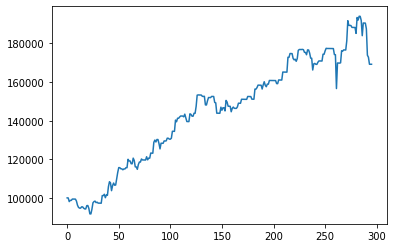

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(account.market_value_all)
plt.show()